In [2]:
import sys
sys.path.append('/home/jovyan/repo/tx-fast-hydrology')

# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Create model inputs

### Load NWM forcings

In [3]:
# Define path for NWM forcings
forcing_path = '../data/20240122_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20240122', '20240124', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [4]:
for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta('120s')
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

In [5]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion

# Add inflow to upstream boundary reaches
upstream_inputs = {
    '5779305' : '5781161',
    '5785187' : '5785899',
    '5786029' : '5785351'
}
for downstream_reach, upstream_reach in upstream_inputs.items():
    inputs[downstream_reach] += streamflow[upstream_reach]

In [6]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

# Gather gage measurements for event period

In [7]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_densified_reach = pd.read_csv('../data/usgs_reach_id_densified.csv', index_col=0) 
usgs_to_densified_reach = usgs_to_densified_reach[['usgs_id','reach_id']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach['usgs_id'] = usgs_to_densified_reach['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach['reach_id'] = usgs_to_densified_reach['reach_id'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach = usgs_to_densified_reach[usgs_to_densified_reach['reach_id'].isin(input_columns)]
usgs_to_densified_reach = pd.Series(usgs_to_densified_reach['reach_id'].values, index=usgs_to_densified_reach['usgs_id'].values)
usgs_to_densified_reach.drop(['8154900', '8154500'], inplace=True)


# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str)
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach)
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]]
measurements = measurements.dropna(axis=1)
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill()

# Set up Kalman Filter

In [8]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and execute simulation

### Prepare model for simulation

In [9]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [10]:
starttime = datetime.datetime.now()
# Simulate models
outputs_da = await simulation.simulate()
endtime = datetime.datetime.now()
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)
print(f"the code took {endtime-starttime} to run")

the code took 0:24:53.920418 to run


# Compare results

### Run model without DA

In [12]:
# Define model file input path
input_path = '../data/travis-county-hi-res-model.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta('120s')
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

starttime = datetime.datetime.now()

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

the code took 0:00:54.038839 to run


### Plot model result vs. KF vs. measurements at gage locations

### Plot map of gains

In [13]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [14]:
den_streams_tx = gpd.read_file('../data/travis_densified_streamlines')
den_streams_tx['reach_id'] = den_streams_tx['reach_id'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['reach_id'].isin(input_columns)].copy()
den_streams_travis['gain'] = den_streams_travis['reach_id'].map(total_gain).fillna(0.).values
den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

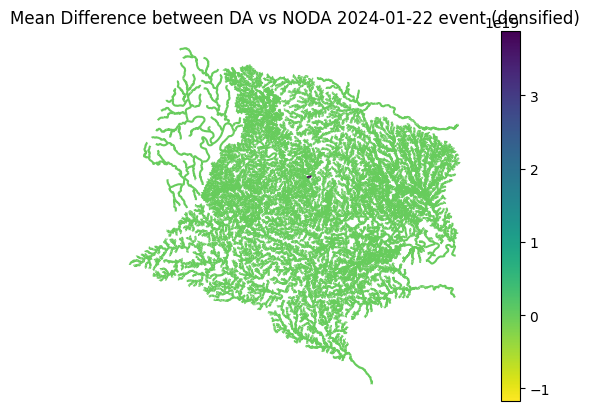

In [15]:
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title("Mean Difference between DA vs NODA 2024-01-22 event (densified)")
_ = plt.axis('off')
plt.savefig('../figures/MeanDifferenceDA_NODA_Den_20240122.png', dpi=600)

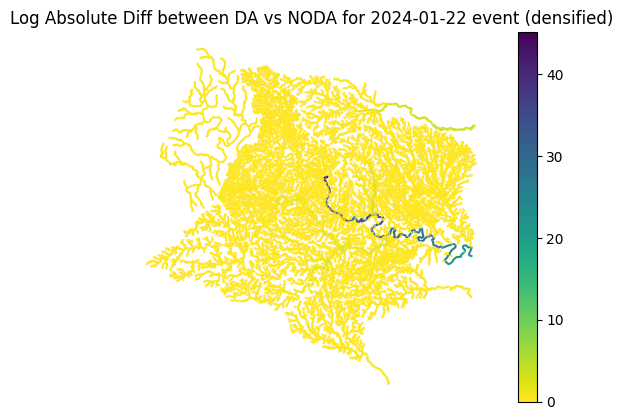

In [16]:
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title("Log Absolute Diff between DA vs NODA for 2024-01-22 event (densified)")
_ = plt.axis('off')
plt.savefig('../figures/LogAbsoluteDifferenceDA_NODA_Den_20240122.png', dpi=600)